In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Price Movement Prediction with DL

Train a classifier in a supervised learning fashion to predict future stock prices trend using LOB data.

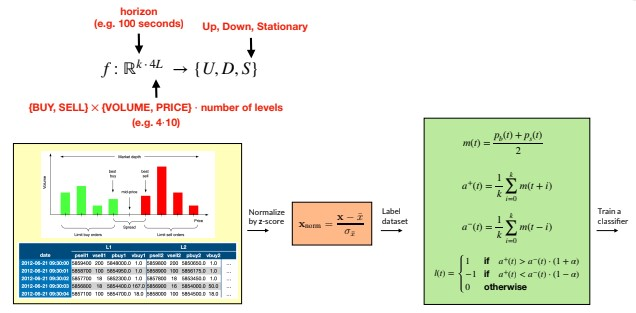

*caveat:* the normalization is performed for the Volumes and the Prices separately

## 🛠️ Data download and initial setup

In [ ]:
"""
!pip install numpy==1.20.0
!pip install -q datascience==0.17.0
!pip install opencv-python==4.5.5.62
!pip install -q albumentations==1.1.0
!pip install -qU pytorch-lightning
!pip install -U wandb
exit(0) # restart the runtime
"""

#!pip list 

In [ ]:
import os
from typing import Any, Dict, Optional, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchmetrics
from numpy.lib.stride_tricks import  sliding_window_view
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.utils.data import DataLoader, Dataset

Make it sure we're logged into W&B so that our experiments can be associated with our account

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: mattiacapparella (use `wandb login --relogin` to force relogin)


True

The first 7 days of the FI-2020 datset are used as training data and the remaining 3 days are used for testing.\
 The training data are divided again with the 80/20 ratio in Training and Validation sets.

In [ ]:
datafolder = "/content/drive/MyDrive/Colab Notebooks/AI4T/CNN Trading Agent/Data/"

old_data = ["train.txt","val.txt","test.txt"]
new_data = ["new_train.txt","new_val.txt","new_test.txt"]

use_new_data = True

train_file, val_file, test_file = new_data if use_new_data else old_data


if not all(
    os.path.isfile(path) for path in [datafolder+train_file, datafolder+val_file, datafolder+test_file]
):
  # data paths
  train_paths = datafolder+"Train_Dst_NoAuction_DecPre_CF_7.txt"
  
  test_paths = [
                datafolder+"Test_Dst_NoAuction_DecPre_CF_7.txt",
                datafolder+"Test_Dst_NoAuction_DecPre_CF_8.txt",
                datafolder+"Test_Dst_NoAuction_DecPre_CF_9.txt",
  ]

  if not all(
    os.path.isfile(path) for path in [train_paths] + test_paths
             ):
    !wget "https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip -P datafolder
    !unzip -n datafolder+"data.zip" - d datafolder
  
  # load train + val data
  train_val_data = np.loadtxt(train_paths, unpack=True)

  # split into train and validation
  train_slice = slice(0, int(0.8 * train_val_data.shape[0]))
  val_slice = slice(int(0.8 * train_val_data.shape[0]), train_val_data.shape[0])

  train_data = train_val_data[train_slice,:]
  val_data = train_val_data[val_slice,:]

  # load test data
  test_data = np.concatenate([np.loadtxt(path, unpack=True) for path in test_paths])

  # save train, val, test data to file
  np.savetxt(datafolder + train_file, train_data)
  np.savetxt(datafolder + val_file, val_data)
  np.savetxt(datafolder + test_file, test_data)


# load train, val, test data
train_data = np.loadtxt(datafolder + train_file, unpack=False)
val_data = np.loadtxt(datafolder + val_file, unpack=False)
test_data = np.loadtxt(datafolder + test_file, unpack=False)

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((203784, 149), (50946, 149), (139567, 149))

For testing purposes, select only a small percentage of data during training, val and testing

In [ ]:
def getPercData(dataset : np.ndarray, perc : float=0.3) -> np.ndarray:
  """Get the first 'perc' instances in the given dataset"""
  return dataset[0:int(dataset.shape[0]*perc), :]


train_data = getPercData(train_data, perc=0.4)
val_data = getPercData(val_data, perc = 0.5)
test_data = getPercData(test_data)

train_data.shape, val_data.shape, test_data.shape

((81513, 149), (25473, 149), (41870, 149))

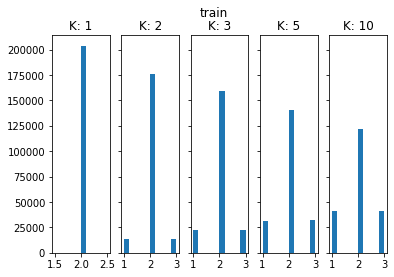

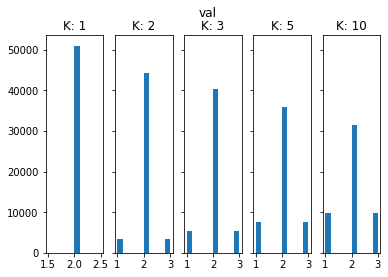

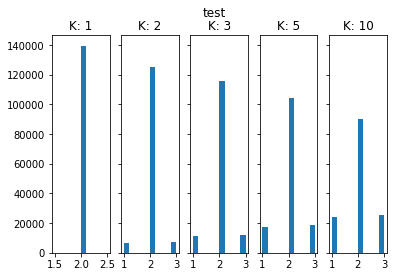

In [ ]:
def plot_target_distributions(labels, horizons=[1,2,3,5,10], title="prova"):
  
  fig, axs = plt.subplots(1,len(horizons), sharey=True)
  fig.suptitle(title)
  for i in range(len(horizons)):
    axs[i].hist(labels[:,i])
    axs[i].set_title("K: {}".format(horizons[i]))  
  plt.show()

plot_target_distributions(train_data[:,-5:], title = "train")
plot_target_distributions(val_data[:,-5:], title = "val")
plot_target_distributions(test_data[:,-5:], title = "test")

## 📋 Dataset: Input and Output

Implement our own PyTorch `Dataset`, by overriding the following 2 methods:



*   `__len__`: returns the length (# examples) of the dataset
*   `__getitem__`: given an index `i`, returns the $i^{th}$ element of the dataset: `dataset[i]`

In our case the $i^{th}$ examples consists of a `dictionary` {"input": ..., "labels": ...} containing the window of *k* trades starting from time $t=i$ and the corresponding price movement computed using the smoothing labelling strategy defined in the picture above


***note***: of the 149 columns of each dataset, we want to extract only the first 4*(l=10)=40 columns, *i.e.* the columns representing the first 10 LOB levels, and the last 5 columns, each one representing a different projection horizon

In [ ]:
def sliding_window_data(data: np.ndarray,
                        labels: np.ndarray,
                        window_length: int) -> Tuple[np.ndarray, np.ndarray]:

                        slided_data = sliding_window_view(data, window_length, axis=0)
                        input_windows = np.einsum("ijk -> ikj", slided_data) # np sliding_window swap the inner dimensions -> take them back 
                        
                        # #windows = len(data) - (window_length - 1) -> we must have the same #labels:
                        #   to do so, we only consider the labels at the "end of each time window" -> the first (`window_length` - 1) labels must be removed
                        window_labels = labels[window_length-1:]

                        return input_windows, window_labels



def preprocess(lob_data: np.ndarray,
               window_length : int,
               prediction_horizon_index: int) -> Tuple[torch.Tensor, torch.Tensor]:
               data_copy = lob_data.copy()

               # As input, take only the first 10 levels of the LOB. 4 cols each level (price, vol for BID and ASK)
               input_data = data_copy[:, :40]

               # As labels, take the last 5 columns of the LOB.
               # The labels are: (1,2,3) -> (📈 stationary, 📉)
               labels = data_copy[:,-5:]
               labels -= 1 # make them 0-based

               # Each of the 5 columns of the labels represents
               # a different projection horizon (i.e. 1,2,3,5,10).
               # Keep just one of those (the last one)
               labels = labels[:, prediction_horizon_index]

               # Split the input data in windows of length `window_length`,
               # and trim the first (`window_length` - 1) elements of the labels
               input_windows, labels = sliding_window_data(input_data, labels, window_length)

               # Cast np arrays into tensor and add one dimension to input to account for convolutions
               input_windows = torch.tensor(input_windows, dtype=torch.float).unsqueeze(1)
               window_labels = torch.tensor(labels, dtype=torch.long)
               return input_windows, window_labels


In [ ]:
class LOBDataset(Dataset):
  def __init__(self,
               lob_data: np.ndarray,
               window_length : int=100,
               projection_horizon_index: int=4) -> None:
               super(LOBDataset, self).__init__()
               self.data, self.labels = preprocess(lob_data, window_length, projection_horizon_index)

  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, idx):
    return {"input": self.data[idx], "labels" : self.labels[idx]}

## Model Architecture

The `nn.Module` class is the base class for all NN modules. We need to instantiate the architecture in the `__init__` method, and we'll need to override the `forward` method, in which we'll have to define the forward step of our neural network.

In [ ]:
class ConvolutionBlock(nn.Module):
  """INSERT DOC"""
  
  
  def __init__(self,
               in_channels: int, out_channels: int, activation_function: nn.Module) -> None:
               super(ConvolutionBlock, self).__init__()

               self.conv_block = nn.Sequential(
                   nn.Conv2d(in_channels, out_channels, (1,2), (1,2)),
                   activation_function,
                   nn.BatchNorm2d(out_channels),
                   activation_function,
                   nn.Conv2d(out_channels, out_channels, (4,1)),
                   nn.BatchNorm2d(out_channels),
                   activation_function,
                   nn.Conv2d(out_channels, out_channels, (4,1)),
                   activation_function,
                   nn.BatchNorm2d(out_channels),
               )
              
  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.conv_block(x)


class InceptionBlock(nn.Module):
  """INSERT DOC"""

  def __init__(self, in_channels: int, out_channels: int) -> None:
    super(InceptionBlock, self).__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (1,1), padding="same"),
        nn.LeakyReLU(0.01),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, (3,1), padding="same"),
        nn.LeakyReLU(0.01),
        nn.BatchNorm2d(out_channels)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (1,1), padding="same"),
        nn.LeakyReLU(0.01),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, (5,1), padding="same"),
        nn.LeakyReLU(0.01),
        nn.BatchNorm2d(out_channels)
    )
    self.block3 = nn.Sequential(
        nn.MaxPool2d((3,1), stride=(1,1), padding=(1,0)),
        nn.Conv2d(in_channels, out_channels, (1,1), padding="same"),
        nn.LeakyReLU(0.01),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return torch.cat( (self.block1(x),self.block2(x),self.block3(x)), dim=1) # append along the cols -> crafting new features for each example

class ShallowLOBNet(nn.Module):
  """INSERT DOC"""
  def __init__(self, num_classes: int = 3) -> None:
    super(ShallowLOBNet, self).__init__()

    # Convolutional Part
    self.conv_block1 = ConvolutionBlock(1, 32, activation_function = nn.LeakyReLU(0.01))
    self.conv_block2 = ConvolutionBlock(32, 32, activation_function = nn.Tanh())

    # non-standard convolution block
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(32, 32, (1,10)),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 32, (4,1)),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 32, (4,1)),
        nn.LeakyReLU(0.01),
        nn.AvgPool2d(kernel_size=(2,1), stride=2),
        nn.Flatten()
        )

    # Classification Head
    self.clf = nn.Linear(32*41, num_classes)

    
  def forward(self, x: torch.Tensor) -> torch.Tensor:

    # Convolutional Part
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)

    # Return softmaxed classes
    return torch.softmax(self.clf(x), dim=1) 


class DeepLOBNet(nn.Module):
  """INSERT DOC"""
  def __init__(self, num_classes: int = 3) -> None:
    super(DeepLOBNet, self).__init__()

    # Convolutional Part
    self.conv_block1 = ConvolutionBlock(1, 32, activation_function = nn.LeakyReLU(0.01))
    self.conv_block2 = ConvolutionBlock(32, 32, activation_function = nn.Tanh())

    # non-standard convolution block
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(32, 32, (1,10)),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 32, (4,1)),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 32, (4,1)),
        nn.LeakyReLU(0.01),
        )
    
    # Inception Part
    self.inception_block = InceptionBlock(32, 64)

    # LSTM layer
    self.lstm = nn.LSTM(input_size = 192, hidden_size=64, batch_first=True)

    # Classification Head
    self.clf = nn.Linear(64, num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    # Convolutional Part
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)

    # Inception Part
    x = self.inception_block(x)
    
    # reshape data to feed lstm
    x = x.permute(0, 2, 1, 3)
    x = x.reshape(x.shape[0], -1, x.shape[2])
    
    x, _ = self.lstm(x) # Tensor of shape (N, L, D * H_out) containing the output features (h_t) from the last layer, for each t. 
    x = x[:, -1, :]

    # Return softmaxed classes
    return torch.softmax(self.clf(x), dim=1) 

where:
> `N` : batch size\
`L` : sequence length \
`D` : 1, since the LSTM is uni-directional\
`H_out:` hidden_size

## 🚆 Training Pipeline

For the training pipeline we are going to use PyTorch Lightning, a high-level programming layer built on top of PyTorch. With PyTorch Lightning ⚡, there is no need to write all the boilerplate code for the backward pass, optimization step, and to define the training and validation loops. There is also quite a number of callbacks defined to use callbacks such as EarlyStopping, ModelCheckpoint...

### PyTorch Lightning ⚡

#### Data Module

In [ ]:
class LOBDataModule(pl.LightningDataModule):
  """PyTorch-Lightning module that allow additional automated optimization such as workload distribution between devices"""

  def __init__(
      self,
      train_data: np.ndarray,
      val_data: np.ndarray,
      test_data: np.ndarray,
      batch_size: int,
      horizon_index: int
      ) -> None:
      super(LOBDataModule).__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.batch_size = batch_size
      self.horizon_index = horizon_index
  
  def setup(self, stage: Optional[str] = None) -> None:
    '''called on each GPU separately - stage defines if we are at fit, val, test or predict step'''
    if stage in [None, "fit"]:
      self.trainset = LOBDataset(self.train_data, projection_horizon_index=self.horizon_index)
      self.valset = LOBDataset(self.val_data, projection_horizon_index=self.horizon_index)
    
    if stage in [None, "test"]:
      self.testset = LOBDataset(self.test_data, projection_horizon_index=self.horizon_index)

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.trainset,
        batch_size = self.batch_size,
        shuffle = True,
        num_workers = 4,
        pin_memory = True, # enables fast data transfer to CUDA-enabled GPUs
    )
  
  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.valset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = 4,
        pin_memory = True,
    )

  def test_dataloader(self) -> DataLoader:
    return DataLoader(
        self.testset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = 4,
        pin_memory = True,
    )

#### Model Module

In [ ]:
class ShallowLOBModule(pl.LightningModule):
  """PyTorch-Lightning module to build models with added functionality to simplify training"""

  def __init__(self, hparams: Dict[str, Any]) -> None:
    super(ShallowLOBModule, self).__init__()
    self.save_hyperparameters(hparams) # automatically log hypts to W&B

    # Model and Criterion
    self.model = ShallowLOBNet(self.hparams.num_classes)
    self.criterion = nn.CrossEntropyLoss()

    # metrics to track
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.train_f1 = torchmetrics.F1()
    self.val_f1 = torchmetrics.F1()
    self.test_acc = torchmetrics.Accuracy()
    self.test_f1 = torchmetrics.F1()
  
  def forward(self, batch: torch.Tensor) -> torch.Tensor:
    '''method used for inference input -> output'''
    return self.model(batch["input"])
  
  def step(self, batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    labels = batch["labels"].view(-1)
    logits = self(batch) # ??? maybe self.forward(batch)
    predictions = torch.argmax(logits, dim=1)
    loss = self.criterion(logits, labels)

    return {"loss": loss, "predictions": predictions}
  
  def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''returns a loss from a single batch and logs some metrics'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])

    self.log_dict(
        {
            "train_loss" : step_output["loss"],
            "train_acc" : accuracy,
            "train_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )

    return step_output["loss"]
  
  def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''compute and logs a loss and some metrics from a single batch'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])

    self.log_dict(
        {
            "val_loss" : step_output["loss"],
            "val_acc" : accuracy,
            "val_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )

  def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''compute and logs a loss and some metrics from a single batch'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])

    self.log_dict(
        {
            "test_loss" : step_output["loss"],
            "test_acc" : accuracy,
            "test_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )
  
  def configure_optimizers(self) -> torch.optim.Optimizer:
    '''defines model optimizer'''
    return torch.optim.Adam(
        self.parameters(),
        lr = self.hparams.lr,
        weight_decay = self.hparams.weight_decay
    )



class DeepLOBModule(pl.LightningModule):
  """PyTorch-Lightning module to build models with added functionality to simplify training"""

  def __init__(self, hparams: Dict[str, Any]) -> None:
    super(DeepLOBModule, self).__init__()
    self.save_hyperparameters(hparams) # automatically log hypts to W&B

    # Model and Criterion
    self.model = DeepLOBNet(self.hparams.num_classes)
    self.criterion = nn.CrossEntropyLoss()

    # metrics to track
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.train_f1 = torchmetrics.F1()
    self.val_f1 = torchmetrics.F1()
    self.test_acc = torchmetrics.Accuracy()
    self.test_f1 = torchmetrics.F1()
  
  def forward(self, batch: torch.Tensor) -> torch.Tensor:
    '''method used for inference input -> output'''
    return self.model(batch["input"])
  
  def step(self, batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    labels = batch["labels"].view(-1)
    logits = self(batch) # ??? maybe self.forward(batch)
    predictions = torch.argmax(logits, dim=1)
    loss = self.criterion(logits, labels)

    return {"loss": loss, "predictions": predictions}
  
  def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''returns a loss from a single batch and logs some metrics'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])

    self.log_dict(
        {
            "train_loss" : step_output["loss"],
            "train_acc" : accuracy,
            "train_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )

    return step_output["loss"]
  
  def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''compute and logs a loss and some metrics from a single batch'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])


    self.log_dict(
        {
            "val_loss" : step_output["loss"],
            "val_acc" : accuracy,
            "val_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )
  

  def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int]) -> torch.Tensor:
    '''compute and logs a loss and some metrics from a single batch'''
    step_output = self.step(batch)
    accuracy = self.train_acc(step_output["predictions"], batch["labels"])
    f1_score = self.train_f1(step_output["predictions"], batch["labels"])

    self.log_dict(
        {
            "test_loss" : step_output["loss"],
            "test_acc" : accuracy,
            "test_f1" : f1_score,
        },
        prog_bar = True,
        on_step = True,
        on_epoch = True
    )
  

  def configure_optimizers(self) -> torch.optim.Optimizer:
    '''defines model optimizer'''
    return torch.optim.Adam(
        self.parameters(),
        lr = self.hparams.lr,
        weight_decay = self.hparams.weight_decay
    )


In [ ]:
def log_confusion_matrix(trainer=None, predictions=None, dataloader=None, flat_class_names=None):
  
  
  if trainer is not None:
    preds = trainer.predict(dataloaders=dataloader) #outputs probability distributions over the classes
  else:
    preds = predictions

  preds = np.vstack(preds)
  preds = torch.Tensor(preds)
  preds = torch.argmax(preds,dim=1).numpy()
  val_labels = torch.Tensor(np.hstack([batch["labels"] for batch in dataloader])).int().numpy()

  # Log confusion matrix
  # the key "conf_mat" is the id of the plot--do not change
  # this is if you want subsequent runs to show up on the same plot
  
  #wandb.log({"conf_mat" : wandb.plot.confusion_matrix(y_true = val_labels,
  #                                                    preds = preds,
  #                                                    class_names = flat_class_names)})
  
  # try also:
  wandb.log({"conf_mat" : wandb.sklearn.plot_confusion_matrix(val_labels,
                                                      preds,
                                                      flat_class_names)})
  


### 🧹 Training with Sweeps

#### Defining sweep configuration
Sweeps can be defined in multiple ways:


*   with a YAML file - best for distributed sweeps and runs from command line
*   with a Python object - best for notebooks

The main items to be define in a sweep are:


*   **Metric** - This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (maximize or minimize).
*   **Search Strategy** - We support several different search strategies with sweeps - `grid`, `random`, `bayes`.
*   **Stopping Criteria** - The strategy for determining when to kill off poorly performing runs, and try more combinations faster. We offer several custom scheduling algorithm like [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) and Envelope.
*   **Parameters** - A dictionary containing the hyperparameters names, and discreet values, max and mix values or distributions from which to pull their values to sweep over.

In [ ]:
sweep_config = {
    "method" : "random", # Random Search
    "metric" : {         # We want to maximize val_accuracy
        "name" : "val_f1_epoch",
        "goal" : "maximize"
    },
    "parameters" : {
        "lr" : {
            # log uniform distribution between exp(min) and exp(max)
            "distribution" : "log_uniform",
            "min" : -9.21, # exp(-9.21) = 1e-4
            "max" : -4.61, # exp(-4.61) = 1e-2
            },
        "batch_size" : {
            "values" : [128, 256]
            },
        "projection_horizon_index" : {
            "values" : [4] # avoid 0,1,2
            },
        "weight_decay" : {
            "values" : [0.01, 0.03, 0.05]
            },
        "num_classes" : {
            "values" : [3]
            },
    }
}

Create a sweep id based on our configuration.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = "AI4T-DeepLOB")

Create sweep with ID: fem6u1qn
Sweep URL: https://wandb.ai/mattiacapparella/AI4T-DeepLOB/sweeps/fem6u1qn


#### Running an agent
We now just need to run an agent against the sweep configuration.
To use the Python sweep API, we define a function that the agent will run, refering to sweep parameters with `wandb.config.my_param`

In [ ]:
def sweep_iteration():
  """Instantiates the wandbLogger, dataModule, the model itself along with the Pl Trainer"""

  # set up W&B logger
  wandb.init() # required to have access to `wandb.config`

  # UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  # "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
  wandb_logger = WandbLogger(offline=False, log_model=True) #  project="AI4T-DeepLOB"

  # setup data - note how it refers to sweep parameters with wandb.config
  datamodule = LOBDataModule(train_data, val_data, test_data, wandb.config.batch_size, wandb.config.projection_horizon_index)


  # Define the callbacks
  early_stop_callback = EarlyStopping(
    monitor = "val_loss_epoch",
    patience = 20,
    verbose = False,
    mode = "min"
  )

  checkpoint_callback = ModelCheckpoint(
    #dirpath = modelfolder,
    filename = "{epoch}_{val_acc:.3f}",
    monitor = "val_loss_epoch",
    save_top_k = 2,
    save_last = True,
    mode = "min"
  )


  # setup model
  hparams = {
    "lr" : wandb.config.lr,
    "weight_decay" : wandb.config.weight_decay,
    "num_classes" : wandb.config.num_classes,
    #"batch_size" : wandb.config.batch_size, # IF IT CRASHES, RESTORE THE LINE
    }

  model = DeepLOBModule(hparams) #ShallowLOBModule(hparams)

  # setup Trainer
  trainer = pl.Trainer(
      logger = wandb_logger,  # W&B integration
      gpus = 1,               # Use the GPU
      max_epochs = 5,
      callbacks = [early_stop_callback, checkpoint_callback],
      log_every_n_steps = 10,
      val_check_interval = 1.0,
      num_sanity_val_steps = 0,
  )

  # Train
  trainer.fit(model, datamodule=datamodule)

  # Test
  test_dataloader = DataLoader(LOBDataset(test_data), batch_size=128, shuffle=False)
  trainer.test(model, dataloaders=test_dataloader)

  # Log confusion matrix
  #log_confusion_matrix(trainer, datamodule.test_dataloader(), flat_class_names=["FALL+","STAT", "RISE+"] )
  log_confusion_matrix(trainer=trainer, dataloader=test_dataloader, flat_class_names=["FALL+","STAT", "RISE+"] )

Finally we just run an agent that will iterate over the sweep parameters with specified search method.

During the runs a WARNING (Config item 'HYPERPARAMETER' was locked by 'sweep' (ignored update)) appears, but it should be ininfluent. See: [wandb issue](https://github.com/wandb/client/issues/2641)

In [ ]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)

### 🏃 Training w/o Sweeps

In [ ]:
#pl.seed_everything(42, workers=True)
hparams = {
    "lr" : 0.000209,
    "weight_decay" : 0.01,
    "num_classes" : 3 ,
    "batch_size" : 128 ,
}

# Define the mapping between horizon days and the relative index
horizon_map = {"1" : 0,
               "2" : 1,
               "3" : 2,
               "5" : 3,
               "10" : 4}


# Select the projection_horizon
projection_horizon = 10
projection_horizon_index = horizon_map[str(projection_horizon)]

# Instantiate the model, the datamosule and the wandbLogger
model = DeepLOBModule(hparams) #ShallowLOBModule(hparams)
datamodule = LOBDataModule(train_data, val_data, test_data, hparams["batch_size"], projection_horizon_index)
wandb_logger = WandbLogger(offline=False, project="AI4T-DeepLOB", log_model=True)

# Define the callbacks
early_stop_callback = EarlyStopping(
    monitor = "val_loss_epoch",
    patience = 20,
    verbose = False,
    mode = "min"
  )

checkpoint_callback = ModelCheckpoint(
    #dirpath = modelfolder,
    filename = "{epoch}_{val_loss:.3f}",
    monitor = "val_loss_epoch",
    save_top_k = 2,
    save_last = True,
    mode = "min"
  )

# Define the Trainer 
trainer = pl.Trainer(
    gpus = 1,
    val_check_interval = 1.0, # use float to check within a training epoch
    max_epochs = 50,
    num_sanity_val_steps = 2,
    logger = wandb_logger,
    callbacks = [early_stop_callback, checkpoint_callback],
    log_every_n_steps = 50,
    flush_logs_every_n_steps=101
)

trainer.fit(model = model, datamodule = datamodule)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: FutureWarning: The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:60: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=101)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  f"Setting `Trainer(flush_logs_every_n_steps={flush_logs_every_n_steps})` is deprecated in v1.5 "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | DeepLOBNet       | 143 K 
1 | criterion | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | val_acc   | Accuracy         | 0     
4 | train_f1  | F1               | 0     
5 | val_f1    | F1               | 0     
6 | test_acc  | Accuracy         | 0     
7 | test_f1   | F1               | 0     
-----------------------------------------------
143 K     Trainable params
0         Non-trainable params
143 K     Total params
0.575     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

When we want to close our W&B run, we call `wandb.finish()`

In [ ]:
# Don't run it if need to test immediately
wandb.finish()

### 🧪 Testing

Once the training has finished, test it on the Test Set and evaluate the model performance on the metrics defined. 

In addition, since the dataset used for the task is quite unbalanced, compute and log the **confusion matrix** to see which are the classes the model fails to classify. 


#### Test with the latest model

In [ ]:
test_dataloader = DataLoader(LOBDataset(test_data), batch_size=128, shuffle=False)

trainer.test(dataloaders=test_dataloader)

In [ ]:
log_confusion_matrix(trainer, test_dataloader, flat_class_names=["FALL+", "STAT", "RISE+"])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `predict(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/AI4T-DeepLOB/15jgbk47/checkpoints/epoch=0_val_acc=0.599.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/AI4T-DeepLOB/15jgbk47/checkpoints/epoch=0_val_acc=0.599.ckpt


Predicting: 955it [00:00, ?it/s]

#### Test with a logged model
In subsequent experiments, we can easily choose a model that was logged previously. Models logged by `WandbLogger` are named `USER/PROJECT/MODEL-RUN_ID:VERSION`.
The version can also be replaced with aliases such as `best` or `latest`.
For example, we can easily access the "best" checkpoint from the **previous run**.

> ***note:*** it may be possible that with sweeps is not possible to do so, since wandb.agent() calls automatically `wandb.finish()` and the references are lost. A possible solution is to pass **hardcoded information**.

In [ ]:
# Solution for the sweep config:
#run_id = "2ptp9zk9"       # this must be fetched from W&B dashboard (and pasted here)
#project = "AI4T-DeepLOB"  # this is fixed 
#entity = "mattiacapparella" # this is fixed

In [ ]:
# Solution for Training w/o Sweeps: we have direct access to the trainer
run_id = trainer.logger.experiment.id
project = trainer.logger.experiment.project
entity = trainer.logger.experiment.entity # the USER

In [ ]:
print("project: {}; entity: {}; run_id: {}".format(project, entity, run_id))

project: AI4T-DeepLOB; entity: mattiacapparella; run_id: 2ptp9zk9


In [ ]:
checkpoint_reference = f'{entity}/{project}/model-{run_id}:best'
checkpoint_reference

'mattiacapparella/AI4T-DeepLOB/model-2ptp9zk9:best'

Files are downloaded and cached with `artifact.download()`

In [ ]:
run = wandb.init(project=project)
#artifact = run.use_artifact('mattiacapparella/AI4T-DeepLOB/model-2ha1g9lo:v0', type='model') # best model so far
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()
artifact_dir

'./artifacts/model-2ha1g9lo:v0'

The artifact folder should now contain our checkpoint.

In [ ]:
from pathlib import Path
list(Path(artifact_dir).glob('*'))

[PosixPath('artifacts/model-2ha1g9lo:v0/model.ckpt')]

Use the `LightningModule` to restore the model from its checkpoint.

In [ ]:
model = DeepLOBModule.load_from_checkpoint(Path(artifact_dir)/'model.ckpt') # ShallowLOBModule

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: FutureWarning: The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


Finally we verify the accuracy of the model on the test set

In [ ]:
test_dataloader = DataLoader(LOBDataset(test_data), batch_size=128, shuffle=False)

pl.Trainer(gpus=1).test(model, dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6525224447250366,
 'test_acc_epoch': 0.6525224447250366,
 'test_f1': 0.6525224447250366,
 'test_f1_epoch': 0.6525224447250366,
 'test_loss': 0.8820909261703491,
 'test_loss_epoch': 0.8820909261703491}
--------------------------------------------------------------------------------


[{'test_acc': 0.6525224447250366,
  'test_acc_epoch': 0.6525224447250366,
  'test_f1': 0.6525224447250366,
  'test_f1_epoch': 0.6525224447250366,
  'test_loss': 0.8820909261703491,
  'test_loss_epoch': 0.8820909261703491}]

In [ ]:
predictions = pl.Trainer(gpus=1).predict(model, dataloaders=test_dataloader)
log_confusion_matrix(predictions=predictions, dataloader=test_dataloader, flat_class_names=["FALL+", "STAT", "RISE+"])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

When we're done with our new experiment, we can just close it

In [ ]:
wandb.finish()